In [1]:
import imageio.v3 as iio
import math
import matplotlib.pyplot as plt
plt.rcParams.update({"mathtext.default": "regular"})

import numpy as np
import os
import torch
from itertools import combinations_with_replacement
from scipy.stats import qmc
from torch import nn
from tqdm.auto import tqdm

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Рассмотрим 10 аналитически заданных функций $u(x,y; a,b) = \sin{a x}\cos{b y}$, где $a, b \in 1,2,7,14$ и $a \le b$. 
Тогда
$$-\Delta u(x,y) = (a^2 + b^2) u(x,y) = f(x,y) \Rightarrow f(x,y)=(a^2+b^2)\sin{ax}\cos{by},$$
$$u(0,y)=u(\pi, y)=0,\quad u(x, 0)=\sin{ax},\quad u(x,\pi)=(-1)^{b}\sin{ax}.$$

In [2]:
examples_cfg = list(combinations_with_replacement((1, 2, 7, 14), 2))

assert len(examples_cfg) == 10

Реализуем классы `FramePointsSampler` для сэмплирования граничных точек и `RectanglePointsSampler` для сэмплирования точек внутри области.

In [3]:
class FramePointsSampler:
    def __init__(self, x_bounds, y_bounds):
        self.l_bounds, self.u_bounds = zip(x_bounds, y_bounds)

    def sample_random(self, n_points: int = 1, device = torch.device("cpu")):
        a, c = self.l_bounds
        b, d = self.u_bounds
        data = torch.zeros((n_points, 2), dtype=torch.float32)
        ind = torch.randint(low=0, high=4, size=(n_points,))

        down, right, up, left = ind == 0, ind == 1, ind == 2, ind == 3

        data[down, 0] = a + torch.rand(down.sum(), dtype=torch.float32) * (b - a)
        data[down, 1] = c

        data[right, 0] = b
        data[right, 1] = c + torch.rand(right.sum(), dtype=torch.float32) * (d - c)

        data[up, 0] = a + torch.rand(up.sum(), dtype=torch.float32) * (b - a)
        data[up, 1] = d

        data[left, 0] = a
        data[left, 1] = c + torch.rand(left.sum(), dtype=torch.float32) * (d - c)

        data.requires_grad = True

        return data[:, 0].to(device), data[:, 1].to(device)

    def sample_uniform(self, n_points: int = 3, device = torch.device("cpu")):
        assert n_points >= 3, "n_points should be greater than 3"

        horizontal_points = torch.linspace(self.l_bounds[0], self.u_bounds[0], n_points, dtype=torch.float32, requires_grad=True)
        vertical_points = torch.linspace(self.l_bounds[1], self.u_bounds[1], n_points, dtype=torch.float32, requires_grad=True)[1:-1]

        down = torch.vstack([horizontal_points, torch.zeros_like(horizontal_points)])
        up = torch.vstack([horizontal_points, torch.full_like(horizontal_points, np.pi)])
        left = torch.vstack([torch.zeros_like(vertical_points), vertical_points])
        right = torch.vstack([torch.full_like(vertical_points, np.pi), vertical_points])

        grid = torch.hstack([down, up, left, right]).T.to(device)

        return grid[:, 0], grid[:, 1]


class RectanglePointsSampler(qmc.LatinHypercube):
    def __init__(self, x_bounds, y_bounds):
        super(RectanglePointsSampler, self).__init__(d=2)
        self.l_bounds, self.u_bounds = zip(x_bounds, y_bounds)

    def sample_random(self, n_points: int = 1, device = torch.device("cpu")):
        data = self.random(n_points)
        data_scaled = qmc.scale(data, self.l_bounds, self.u_bounds)
        grid = torch.tensor(data_scaled, dtype=torch.float32, requires_grad=True).to(device)

        return grid[:, 0], grid[:, 1]

    def sample_uniform(self, n_points: int = 3, device = torch.device("cpu")):
        assert n_points >= 3, "n_points should be greater than 3"

        horizontal_points = torch.linspace(self.l_bounds[0], self.u_bounds[0], n_points, dtype=torch.float32, requires_grad=True)
        vertical_points = torch.linspace(self.l_bounds[1], self.u_bounds[1], n_points, dtype=torch.float32, requires_grad=True)
        grid = torch.cartesian_prod(horizontal_points, vertical_points).to(device)

        return grid[:, 0], grid[:, 1]

Изобразим работу генераторов точек как для случайного сэмплирования, так и для равномерной сетки.

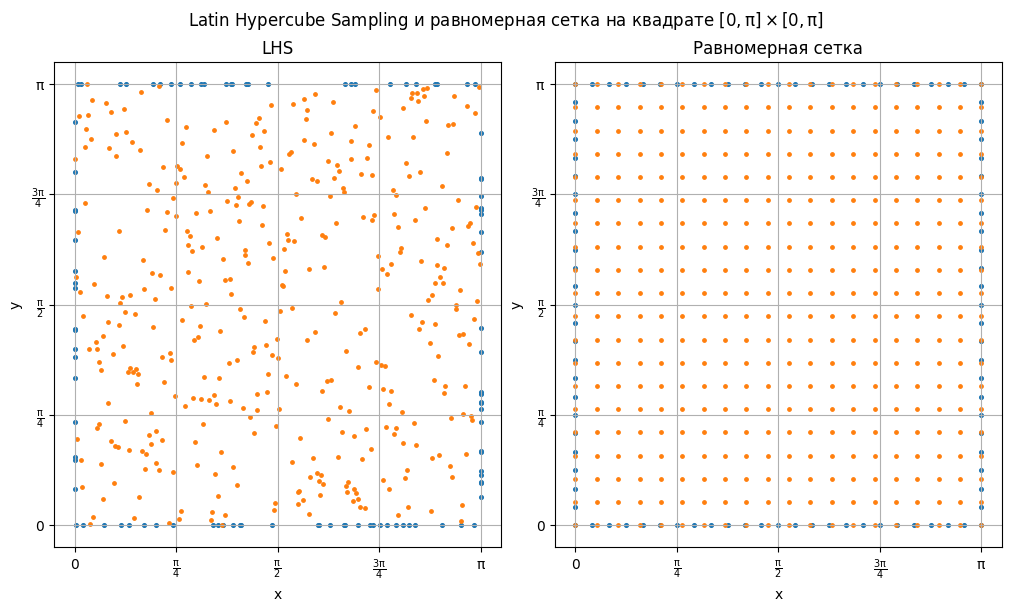

In [4]:
beautiful_labels = [r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$", r"$\pi$"]

bc_sampler = FramePointsSampler([0, np.pi], [0, np.pi])
pde_sampler = RectanglePointsSampler([0, np.pi], [0, np.pi])

with torch.no_grad():
    bc_data = bc_sampler.sample_random(100)
    pde_data = pde_sampler.sample_random(400)
    bc_grid = bc_sampler.sample_uniform(25)
    pde_grid = pde_sampler.sample_uniform(20)

    fig, ax = plt.subplots(1, 2, figsize=(10, 6), constrained_layout=True)
    fig.suptitle("Latin Hypercube Sampling и равномерная сетка на квадрате $[0,\\pi]\\times [0, \\pi]$")
    ax[0].scatter(bc_data[0], bc_data[1], s=7)
    ax[0].scatter(pde_data[0], pde_data[1], s=6)
    ax[0].set_title("LHS")
    ax[1].scatter(bc_grid[0], bc_grid[1], s=7)
    ax[1].scatter(pde_grid[0], pde_grid[1], s=6)
    ax[1].set_title("Равномерная сетка")
    for ax_i in ax:
        ax_i.set_xticks(np.linspace(0, np.pi, len(beautiful_labels)))
        ax_i.set_xticklabels(beautiful_labels)
        ax_i.set_yticks(np.linspace(0, np.pi, len(beautiful_labels)))
        ax_i.set_yticklabels(beautiful_labels)
        ax_i.set_xlabel("$x$")
        ax_i.set_ylabel("$y$")
        ax_i.grid(True)
    plt.show()

Далее реализуем полносвязный персептрон с активациями `Tanh`. Он будет служить решением задачи Дирихле для уравнения Пуассона.

In [5]:
class Dense(nn.Module):
    def __init__(self, input_size, output_size, activation=nn.Tanh):
        super(Dense, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        nn.init.xavier_uniform_(self.linear.weight)
        self.linear.bias.data.fill_(0.)
        self.activation = activation()

    def forward(self, x):
        x = self.linear(x)
        return self.activation(x)


class MLP(nn.Module):
    def __init__(self, input_size=2, output_size=1, hidden_size=75, n_layers=4, activation=nn.Tanh):
        super(MLP, self).__init__()
        self.intro = Dense(input_size, hidden_size, activation=nn.Tanh)
        self.hidden = nn.Sequential()
        for _ in range(n_layers):
            self.hidden.append(Dense(hidden_size, hidden_size, activation=nn.Tanh))
        self.outro = Dense(hidden_size, output_size, activation=nn.Identity)

    def forward(self, x, y):
        x = torch.stack([x, y], dim=1)
        x = self.intro(x)
        x = self.hidden(x)
        return self.outro(x)

Убедимся, что модель корректно отрабатывает на сэмплированных множествах.

In [6]:
model = MLP()
model(*bc_data).shape, model(*pde_data).shape

(torch.Size([100, 1]), torch.Size([400, 1]))

Реализуем непосредственно `PINN` с возможностью обучения модели и вычисления лапласиана.

In [7]:
class PINN:
    def __init__(self, x_bounds=(0, np.pi), y_bounds=(0, np.pi)):
        self.pde_sampler = RectanglePointsSampler(x_bounds, y_bounds)
        self.bc_sampler = FramePointsSampler(x_bounds, y_bounds)

    def _save_frame(self, model, path, iter_num=0):
        if not os.path.exists(f"frames_{path}"):
            os.makedirs(f"frames_{path}")
        model.eval()
        with torch.no_grad():
            xy = self.pde_sampler.sample_uniform(1_000, device=DEVICE)
            u_pred = np.rot90(model(*xy).cpu().numpy().reshape(1_000, 1_000))
            plt.imsave(f"frames_{path}/{iter_num}.png", u_pred, cmap="gist_rainbow_r")

    def _save_movie(self, path):
        images = []
        for filename in os.listdir(f"frames_{path}"):
            images.append(iio.imread(f"frames_{path}/{filename}"))
        iio.imwrite(f"{path}.gif", images, duration=500) # 2 FPS
    

    def train(self, f, g, n_iterations=1_000, solution=None, movie_path=None, iters_for_frame=500):
        model = MLP().to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
        criterion = nn.MSELoss(reduction="mean").to(DEVICE)

        loss_pde_history = []
        loss_bc_history = []
        loss_history = []
        if movie_path is not None:
            self._save_frame(model, movie_path)

        loss_to_cpu = lambda loss: loss.detach().cpu().item()

        model.train()
        for iter_num in (pbar := tqdm(range(n_iterations))):
            pde_data = self.pde_sampler.sample_random(1_000, device=DEVICE)
            bc_data = self.bc_sampler.sample_random(500, device=DEVICE)

            u_pde = model(*pde_data)
            u_bc = model(*bc_data)

            loss_pde = criterion(-PINN.get_laplacian(u_pde, *pde_data), f(*pde_data))
            loss_bc = criterion(u_bc, g(*bc_data))
            loss = loss_pde + loss_bc

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (iter_num+1) % 100 == 0:
                pbar.set_description(f"Loss pde: {loss_to_cpu(loss_pde):.7f}, Loss bc: {loss_to_cpu(loss_bc):.7f}, Loss total : {loss_to_cpu(loss):.7f}")
                loss_pde_history.append(loss_pde.detach().cpu().item())
                loss_bc_history.append(loss_bc.detach().cpu().item())
                loss_history.append(loss.detach().cpu().item())

            if (iter_num+1) % iters_for_frame == 0:
                if movie_path is not None:
                    self._save_frame(model, movie_path, iter_num+1)
                model.train()

        model.eval()
        pde_data = self.pde_sampler.sample_random(1_000, device=DEVICE)
        bc_data = self.bc_sampler.sample_random(500, device=DEVICE)
        u_pde = model(*pde_data)
        u_bc = model(*bc_data)
        u = torch.vstack([u_pde, u_bc])

        if solution is not None:
            u_pde_true = solution(*pde_data)
            u_bc_true = solution(*bc_data)
            u_true = torch.vstack([u_pde_true.view(-1, 1), u_bc_true.view(-1, 1)])
            print(
                f"Solution L2 absolute error: {torch.linalg.norm(u_true - u, ord=2)}",
                f"Solution L2 relative error: {torch.linalg.norm(u_true - u, ord=2) / torch.linalg.norm(u, ord=2)}",
                f"Solution C absolute error: {torch.abs(u_true - u).max()}",
                f"Solution C relative error: {torch.abs(u_true - u).max() / torch.abs(u_true).max()}",
                sep="\n"
            )

        residual = -PINN.get_laplacian(u_pde, *pde_data) - f(*pde_data)
        print(
            f"Residual L2 error: {torch.linalg.norm(residual, ord=2)}",
            f"Residual C error: {torch.abs(residual).max()}",
            sep="\n"
        )

        if movie_path is not None:
            self._save_movie(movie_path)

        losshistory = {
            "pde_loss": loss_pde_history,
            "bc_loss": loss_bc_history,
            "loss": loss_history
        }
        return model, losshistory

    @staticmethod
    def get_laplacian(u, x, y):
        du_dx = torch.autograd.grad(
            u,
            x,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True
        )[0]
        du_dy = torch.autograd.grad(
            u,
            y,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True
        )[0]
        d2u_dx2 = torch.autograd.grad(
            du_dx,
            x,
            grad_outputs=torch.ones_like(du_dx),
            create_graph=True,
            retain_graph=True
        )[0]
        d2u_dy2 = torch.autograd.grad(
            du_dy,
            y,
            grad_outputs=torch.ones_like(du_dy),
            create_graph=True,
            retain_graph=True
        )[0]
        return d2u_dx2 + d2u_dy2

In [8]:
def get_f(a, b):
    def f(x, y):
        return (a**2 + b**2) * torch.sin(a * x) * torch.cos(b * y)
    return f


def get_g(a, b):
    def g(x, y):
        boundary = torch.zeros_like(x)
        on_bottom = torch.isclose(y, torch.tensor(0.))
        on_top = torch.isclose(y, torch.tensor(np.pi))
        boundary[on_bottom] = torch.sin(a * x)[on_bottom]
        boundary[on_top] = (-1)**b * torch.sin(a * x)[on_top]
        return boundary.reshape(-1, 1)
    return g


def get_solution(a, b):
    def solution(x, y):
        return torch.sin(a * x) * torch.cos(b * y)
    return solution

In [9]:
n_iterations = 15_000

In [10]:
results = {}
for a, b in examples_cfg:
    print("\n\n============================================")
    print(f"Training model for u(x,y)=sin({a}x)*cos({b}y)")

    f = get_f(a, b)
    g = get_g(a, b)
    solution = get_solution(a, b)
    solution_repr = r"$u(x,y)=\sin{" + str(a) + r"x}\cdot\cos{" + str(b) + "y}$"
    movie_path = f"sin{a}x_cos{b}y"
    pinn = PINN()
    model, losshistory = pinn.train(
        f, 
        g, 
        n_iterations=n_iterations,
        solution=solution,
        movie_path=movie_path,
    )

    results[(a, b)] = {
        "f": f,
        "g": g,
        "solution": solution,
        "solution_repr": solution_repr,
        "movie_path": movie_path,
        "model": model,
        "losshistory": losshistory
    }



Training model for u(x,y)=sin(1x)*cos(1y)


  0%|          | 0/15000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Solution L2 absolute error: 0.07039488106966019
Solution L2 relative error: 0.003629869781434536
Solution C absolute error: 0.00627860426902771
Solution C relative error: 0.00627860426902771
Residual L2 error: 0.05342647805809975
Residual C error: 0.008559226989746094


Training model for u(x,y)=sin(1x)*cos(2y)


  0%|          | 0/15000 [00:00<?, ?it/s]

Solution L2 absolute error: 0.40990519523620605
Solution L2 relative error: 0.021067116409540176
Solution C absolute error: 0.028722131624817848
Solution C relative error: 0.02872234582901001
Residual L2 error: 0.5189487338066101
Residual C error: 0.040868520736694336


Training model for u(x,y)=sin(1x)*cos(7y)


  0%|          | 0/15000 [00:00<?, ?it/s]

Solution L2 absolute error: 1.8233225345611572
Solution L2 relative error: 0.09575176239013672
Solution C absolute error: 0.15944147109985352
Solution C relative error: 0.1594414860010147
Residual L2 error: 32.97954177856445
Residual C error: 3.1604394912719727


Training model for u(x,y)=sin(1x)*cos(14y)


  0%|          | 0/15000 [00:00<?, ?it/s]

Solution L2 absolute error: 11.220402717590332
Solution L2 relative error: 0.5259095430374146
Solution C absolute error: 0.8561649918556213
Solution C relative error: 0.8561654090881348
Residual L2 error: 66.49490356445312
Residual C error: 12.574617385864258


Training model for u(x,y)=sin(2x)*cos(2y)


  0%|          | 0/15000 [00:00<?, ?it/s]

Solution L2 absolute error: 0.2842482030391693
Solution L2 relative error: 0.014611468650400639
Solution C absolute error: 0.0385458879172802
Solution C relative error: 0.038547296077013016
Residual L2 error: 0.39067286252975464
Residual C error: 0.05742090940475464


Training model for u(x,y)=sin(2x)*cos(7y)


  0%|          | 0/15000 [00:00<?, ?it/s]

Solution L2 absolute error: 1.0791728496551514
Solution L2 relative error: 0.054602861404418945
Solution C absolute error: 0.13703501224517822
Solution C relative error: 0.1370370239019394
Residual L2 error: 11.292590141296387
Residual C error: 1.2172679901123047


Training model for u(x,y)=sin(2x)*cos(14y)


  0%|          | 0/15000 [00:00<?, ?it/s]

Solution L2 absolute error: 19.232820510864258
Solution L2 relative error: 0.6743093729019165
Solution C absolute error: 1.8792030811309814
Solution C relative error: 1.8793467283248901
Residual L2 error: 112.68172454833984
Residual C error: 20.702800750732422


Training model for u(x,y)=sin(7x)*cos(7y)


  0%|          | 0/15000 [00:00<?, ?it/s]

Solution L2 absolute error: 8.775664329528809
Solution L2 relative error: 0.40563449263572693
Solution C absolute error: 1.0517975091934204
Solution C relative error: 1.051800012588501
Residual L2 error: 20.3882999420166
Residual C error: 3.1261329650878906


Training model for u(x,y)=sin(7x)*cos(14y)


  0%|          | 0/15000 [00:00<?, ?it/s]

Solution L2 absolute error: 69.88348388671875
Solution L2 relative error: 1.003238320350647
Solution C absolute error: 5.140899658203125
Solution C relative error: 5.1410417556762695
Residual L2 error: 2419.10302734375
Residual C error: 239.87217712402344


Training model for u(x,y)=sin(14x)*cos(14y)


  0%|          | 0/15000 [00:00<?, ?it/s]

Solution L2 absolute error: 19.319826126098633
Solution L2 relative error: 6.586520195007324
Solution C absolute error: 1.1367017030715942
Solution C relative error: 1.1367144584655762
Residual L2 error: 6153.47900390625
Residual C error: 391.3031311035156


In [11]:
cmap="gist_rainbow_r"

arr_to_img = lambda arr, n: np.rot90(arr.reshape(n, n))

x012 = [np.pi/8., np.pi/2., 7.*np.pi/8.]
x012_repr = [r"\frac{\pi}{8}", r"\frac{\pi}{2}", r"\frac{7\pi}{8}"]

@torch.no_grad()
def plot_model(model_cfg, N):
    xy = pde_sampler.sample_uniform(N)
    solution, solution_repr, model = (model_cfg[attr] for attr in ("solution", "solution_repr", "model"))
    model = model.to("cpu")
    u_true, u_pred = solution(*xy).numpy().reshape(-1), model(*xy).numpy().reshape(-1)
    
    fig, ax = plt.subplots(2, 3, figsize=(10, 6), constrained_layout=True)
    fig.suptitle(model_cfg["solution_repr"], fontsize=16)

    ax[0, 0].imshow(arr_to_img(u_true, N), cmap=cmap)
    ax[0, 0].set_title("$u(x,y)$")

    im_01 = ax[0, 1].imshow(arr_to_img(u_pred, N), cmap=cmap)
    ax[0, 1].set_title("$model(x,y)$")

    im_02 = ax[0, 2].imshow(arr_to_img(np.abs(u_pred - u_true), N), cmap=cmap)
    ax[0, 2].set_title("$| u(x,y)-model(x,y)|$")

    for i in range(3):
        ax[0, i].set_xticks(np.linspace(0, N, len(beautiful_labels)))
        ax[0, i].set_xticklabels(beautiful_labels)
        ax[0, i].set_xlabel("$x$")

        ax[0, i].set_yticks(np.linspace(0, N, len(beautiful_labels)))
        ax[0, i].set_yticklabels(beautiful_labels[::-1])
        ax[0, i].set_ylabel("$y$")

        xy = (torch.full((N,), x012[i]), torch.linspace(0., np.pi, N))
        u_pred = model(*xy).numpy().reshape(-1)
        u_true = solution(*xy).numpy().reshape(-1)

        ax[1, i].plot(np.linspace(0., np.pi, N), u_true, linestyle="solid", color="blue")
        ax[1, i].plot(np.linspace(0., np.pi, N), u_pred, linestyle="dashed", color="red")

        ax[1, i].set_title("$x=" + x012_repr[i] + "$")
        ax[1, i].set_xticks(np.linspace(0, np.pi, len(beautiful_labels)))
        ax[1, i].set_xticklabels(beautiful_labels)
        ax[1, i].set_xlabel("$y$")

        ax[1, i].set_ylabel("$u(x,y)$")
        ax[1, i].set_ylim([-1., 1.])
        ax[1, i].grid(True)        
    
    cbar_u = plt.colorbar(im_01, ax=(ax[0, 0], ax[0, 1]), shrink=0.8)
    cbar_d = plt.colorbar(im_02, ax=ax[0, 2], shrink=0.8)
    
    for cbar in (cbar_u, cbar_d):
        cbar.formatter.set_powerlimits((0, 0))
        cbar.formatter.set_useMathText(True)
    
    plt.show()

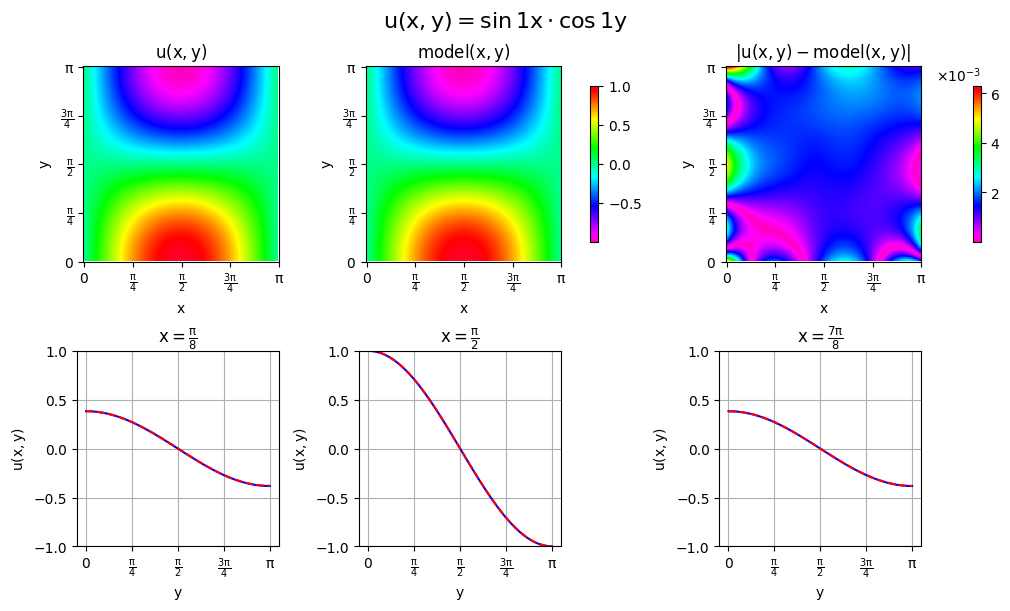

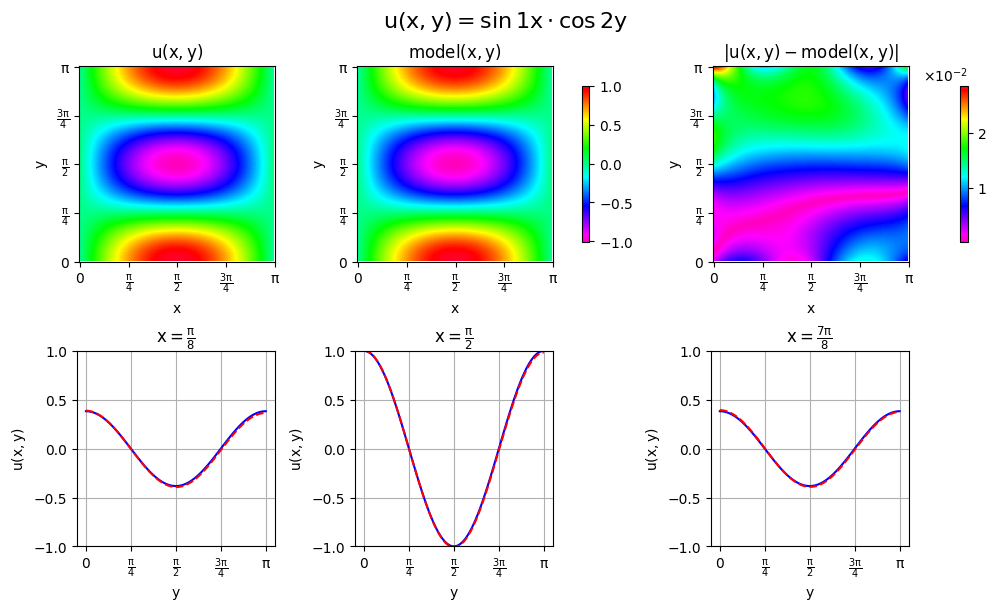

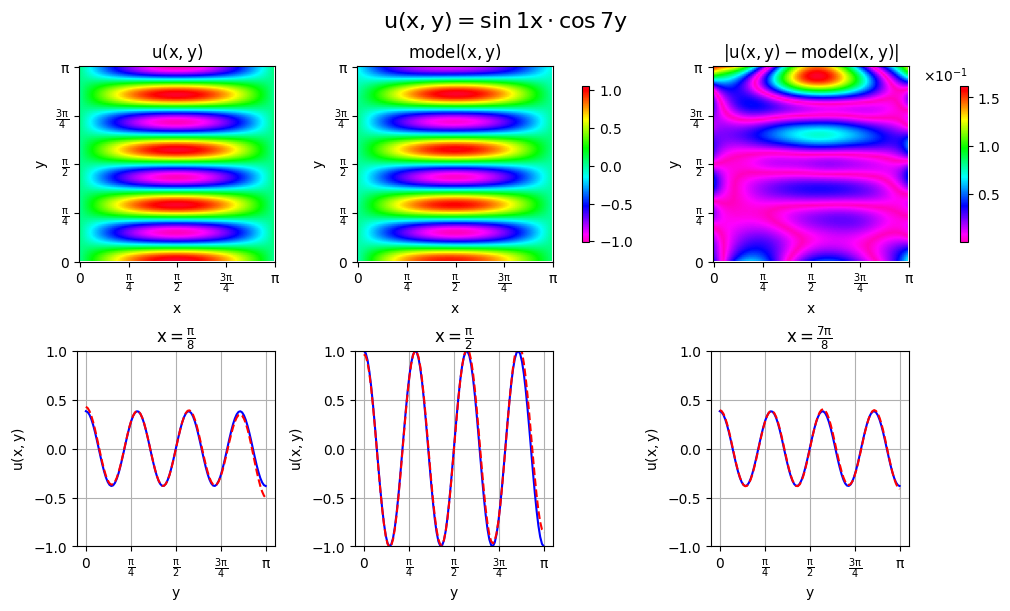

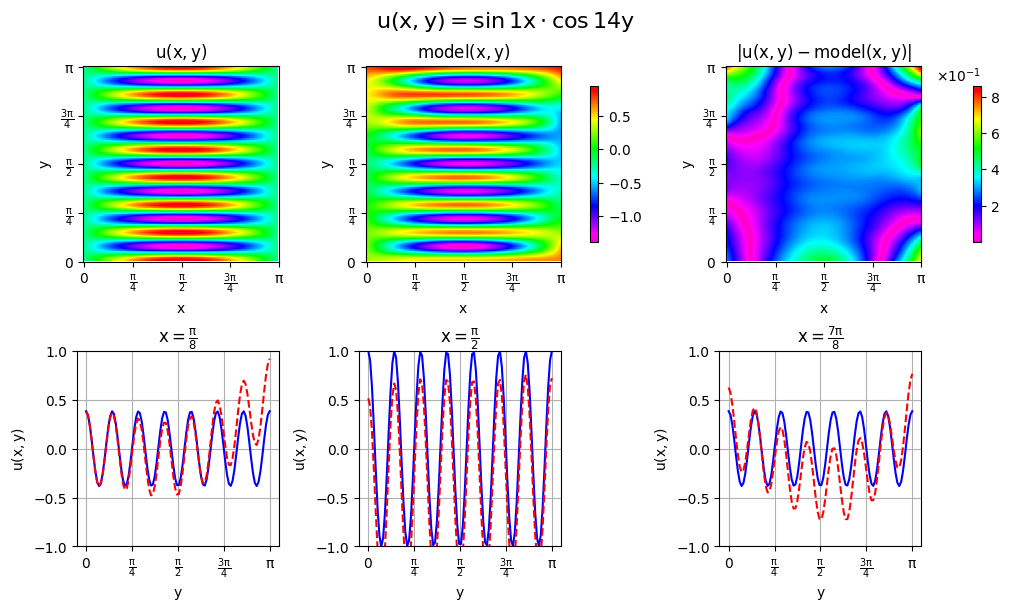

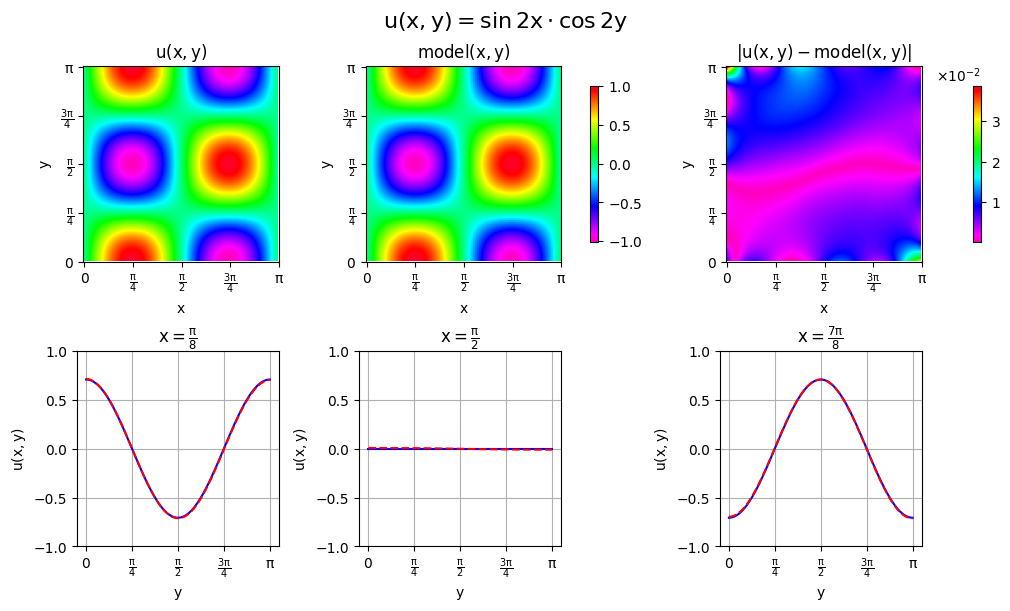

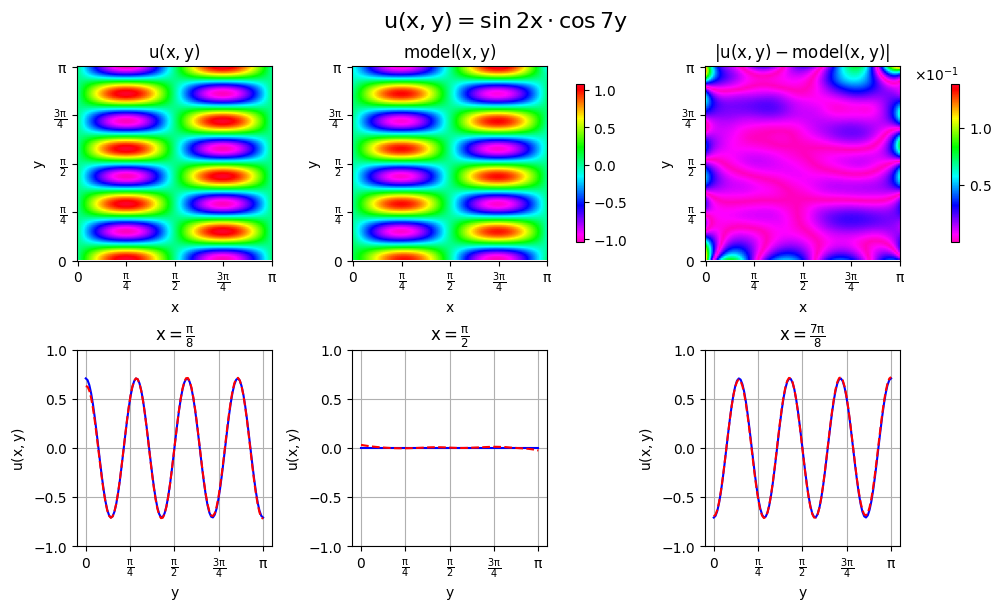

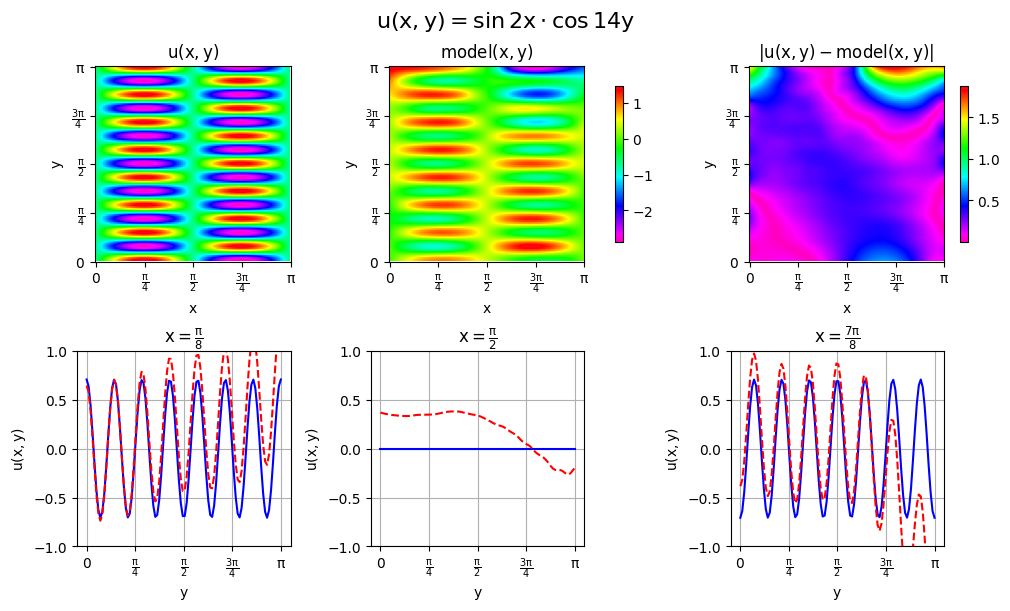

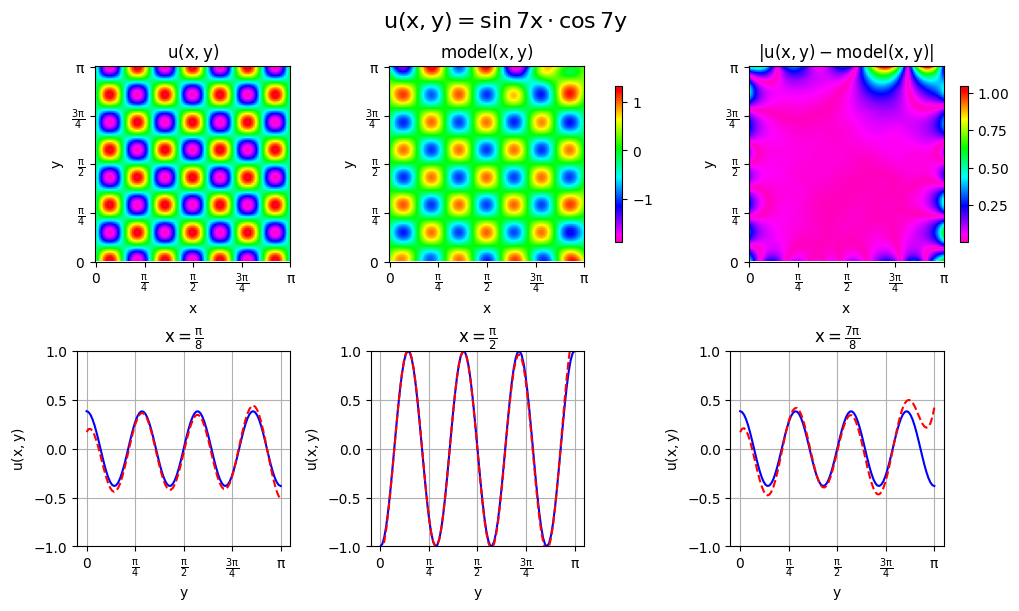

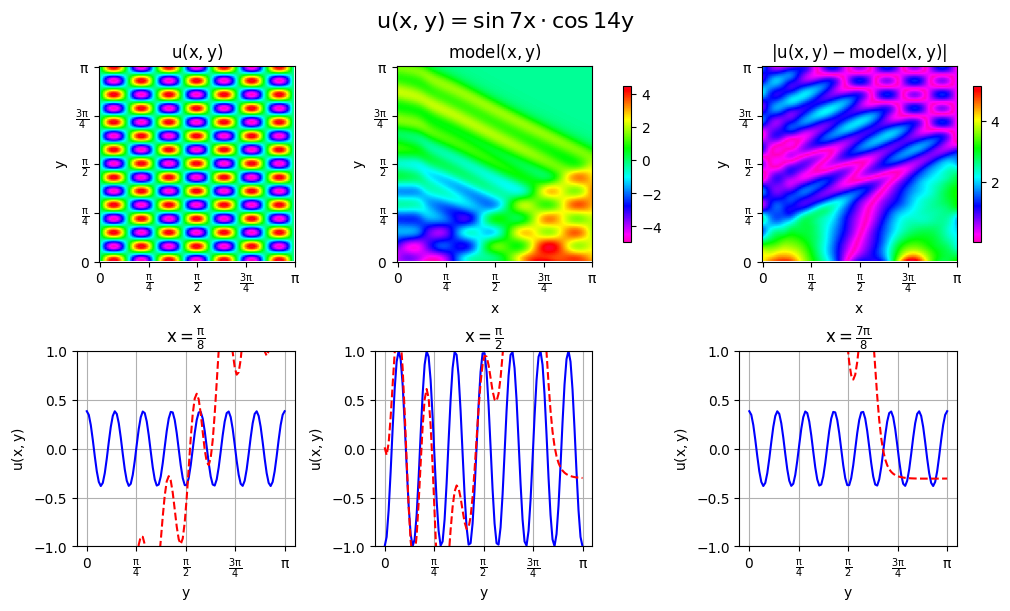

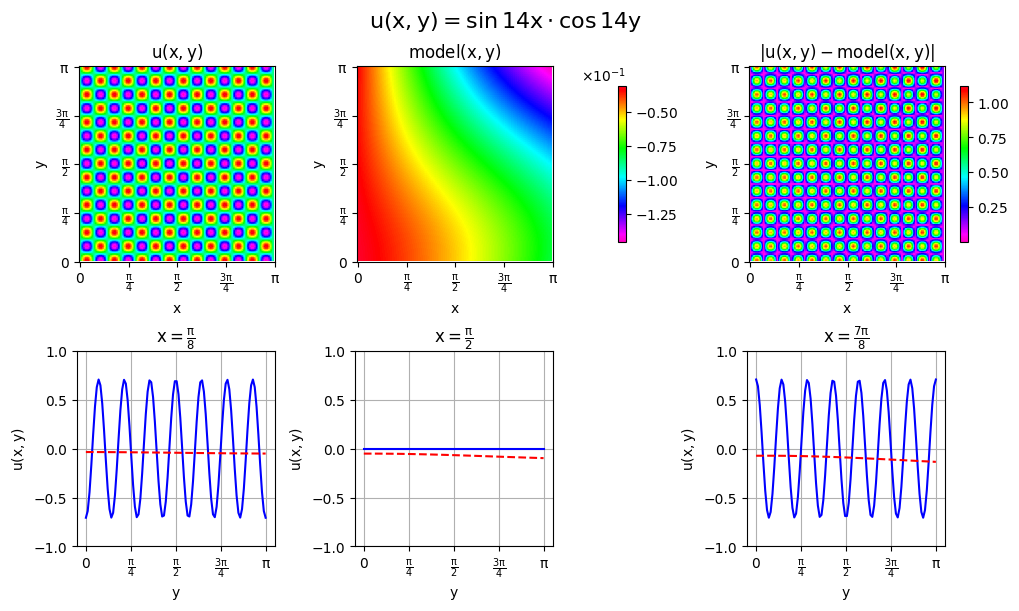

In [12]:
for frequencies in examples_cfg:
    plot_model(results[frequencies], 100)